In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score



import scipy
from scipy import stats
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline

### Загрузим данные
**(Насколько я понял)** default_0 = 0 - означает, что дефолта не случилось, а значит клиент отдал кредит (это хороший клиент), а default_0 = 1 - означает, что случился дефолт и клиент принес убытки. <br>
Поменяем целевую переменную: (0 -> 1, 1 -> 0) и теперь 1 - отдал кредит, 0 - не отдал кредит.

In [43]:
dev = pd.read_csv('dev.csv', sep=';')
dev.dropna(inplace=True)
# dev = dev.reindex(sorted(dev.columns), axis=1)
dev['default_0'] = dev['default_0'].map({0: 1, 1: 0}) 
dev.tail()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_0
19312,23995,100000.0,1,1,2,38,0,-1,-1,0,...,70626.0,69473.0,55004.0,2000.0,111784.0,4000.0,3000.0,2000.0,2000.0,1
19313,23997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,1
19314,23998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,0
19315,23999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,0
19316,24000,50000.0,1,2,1,46,0,0,0,0,...,36535.0,32428.0,15313.0,2078.0,1800.0,1430.0,1000.0,1000.0,1000.0,0


### Смотрим соотношения классов

In [44]:
dev['default_0'].value_counts()

1    15068
0     4249
Name: default_0, dtype: int64

## Основная идея
Предположим, что в Банке имеется лишь та модель, которую я сделал ниже. <br><br>
Мы имеем данные (таблица dev) о клиентах. Чтобы оценить качество нашей модели, предлагаю данные dev разбить на обучающую и тестовую выборки в соотношении 80/20 (как и данные в задании имеют соотношение dev/valid - 80/20). <br><br>
Я выбрал метрику точности (Precision) потому как у нас большой штраф, если клиенту выдали кредит и случился дефолт (штраф 5000 у.е.) нежели если мы не выдали "хорошему" клиенту кредит (штраф 0 у.е.).

In [45]:
# тут делим на категориальные и числовые признаки

cols_prep = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5','BILL_AMT6',
             'LIMIT_BAL','PAY_AMT1', 'PAY_AMT2','PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6','AGE']
cols_no_prep = ['EDUCATION','MARRIAGE','SEX','PAY_1','PAY_2','PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
col_y = ['default_0']

In [46]:
y = dev['default_0']
X_train, X_test, y_train, y_test = train_test_split(dev, y, test_size=0.2, random_state=1)

In [47]:
X_train.shape, X_test.shape

((15453, 25), (3864, 25))

In [48]:
scaler = StandardScaler() 

X_train_prep = scaler.fit_transform(X_train[cols_prep].values) # скейлим числовые признаки 
X_test_prep = scaler.transform(X_test[cols_prep].values)       # скейлим числовые признаки 

x_train_full = np.hstack((X_train_prep, X_train[cols_no_prep].values)) # конкатеначим с категориальными
x_test_full = np.hstack((X_test_prep, X_test[cols_no_prep].values))    # конкатеначим с категориальными

In [49]:
N_ = 200
forest = RandomForestClassifier(n_estimators=N_, random_state=1, n_jobs=-1) 
forest.fit(x_train_full, y_train.values)
y_pred = forest.predict(x_test_full)
prec = precision_score(y_test, y_pred)

In [50]:
print(f"Точность: {100*prec}")

Точность: 83.80447585394582


### Распределение тестовой выборки и valid
Посмотрим как распределены тестовая выборка и выборка из вкладки "valid". <br>
Если они распределены одинаково, то мы можем ожидать, что точность на выборке "valid" будет равна точности на тестовой выборке, а значит дефолт случится у 16.2% клиентов, которых мы определили в "хороших".

In [51]:
valid = pd.read_csv('valid.csv', sep=';')
valid.tail()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
4678,23985,50000.0,1,2,1,44,1,2,2,2,...,33101.0,28192,22676,14647,2300.0,1700.0,0,517,503.0,585.0
4679,23988,240000.0,1,1,2,30,-2,-2,-2,-2,...,0.0,0,0,0,0.0,0.0,0,0,0.0,0.0
4680,23991,250000.0,1,1,1,34,0,0,0,0,...,243075.0,245750,175005,179687,65000.0,8800.0,9011,6000,7000.0,6009.0
4681,23994,10000.0,1,3,1,43,0,0,0,-2,...,0.0,0,0,0,2000.0,0.0,0,0,0.0,0.0
4682,23996,80000.0,1,2,2,34,2,2,2,2,...,79384.0,77519,82607,81158,7000.0,3500.0,0,7000,0.0,4000.0


In [62]:
### "SEX" имеет распределение бернулли, поэтому построим доверительный интервал для разности двух долей
def proportions_confint_diff_ind(sample1, sample2, alpha): 
    sample1 = sample1.map({1: 0, 2:1}) 
    sample2 = sample2.map({1: 0, 2:1}) 
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

Attr: LIMIT_BAL | U p-value: 0.47447929883994905
Attr: EDUCATION | U p-value: 0.47249143378633035
Attr: MARRIAGE | U p-value: 0.22745650459624278
Attr: BILL_AMT1 | U p-value: 0.48275676918147065
Attr: PAY_AMT5 | U p-value: 0.1701398437501523
Attr: AGE | U p-value: 0.3851620893297286
Attr: PAY_1 | U p-value: 0.25191675654994816
Attr: SEX
a=0.01: (-0.04215097314693721, -0.0013100298424999109)
a=0.05: (-0.037268560996769666, -0.00619244199266745)
a=0.1: (-0.03477045209040985, -0.00869055089902727)


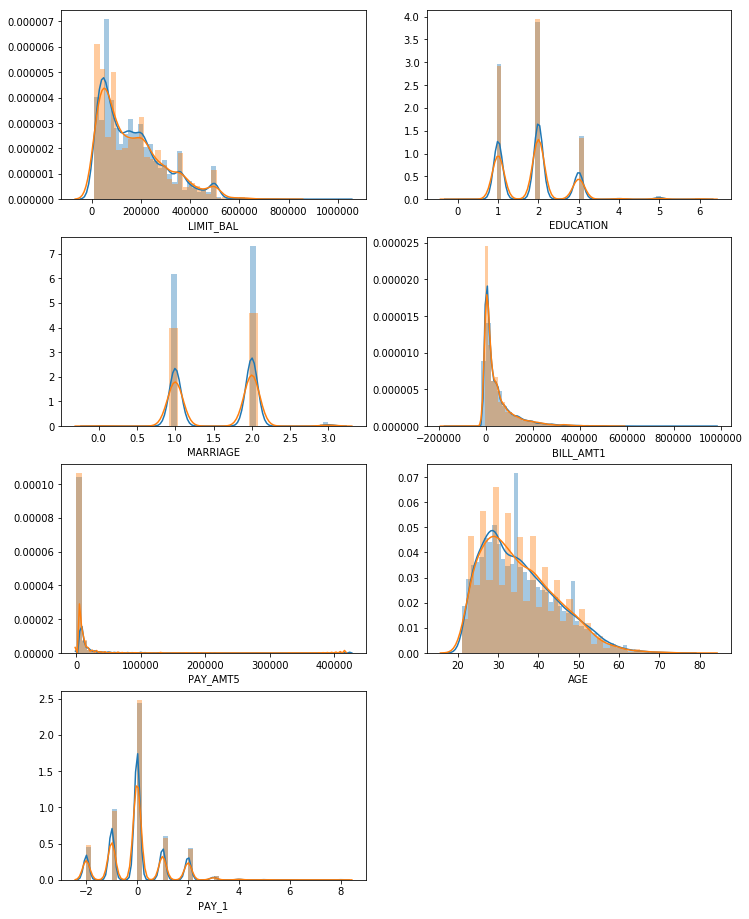

In [63]:
cols = ['LIMIT_BAL','EDUCATION','MARRIAGE','BILL_AMT1','PAY_AMT5','AGE','PAY_1']
plt.figure(figsize=(12, 16))
for i,j in enumerate(cols):
    plt.subplot(4, 2, i+1)
    sns.distplot(dev[j])
    sns.distplot(valid[j])
    u, p = stats.mannwhitneyu(dev[j], valid[j])
    print(f'Attr: {j} | U p-value: {p}')

print("Attr: SEX")
for a in [0.01, 0.05, 0.1]:
    print(f"a={a}: {proportions_confint_diff_ind(dev['SEX'], valid['SEX'], a)}")

###  Отлично. 
Далее мы обучаем нашу модель на всей выборки dev. <br>
Тестируем на выборке valid. <br>
И оцениваем прибыль от кредитного продукта Rev = $precision$ * 1500 * $num$ - (1-$precision$) * 5000 * $num$, <br>
где $num$ -- количество 1 из всего массива предсказанных меток класса, $precision$ -- оценка точности 83.8%.

In [56]:
y_train = dev['default_0']
X_train = dev
X_test = valid

scaler = StandardScaler() 

X_train_prep = scaler.fit_transform(X_train[cols_prep].values) # скейлим числовые признаки 
X_test_prep = scaler.transform(X_test[cols_prep].values)       # скейлим числовые признаки 

x_train_full = np.hstack((X_train_prep, X_train[cols_no_prep].values)) # конкатеначим с категориальными
x_test_full = np.hstack((X_test_prep, X_test[cols_no_prep].values))    # конкатеначим с категориальными

In [57]:
N_ = 200
forest = RandomForestClassifier(n_estimators=N_, random_state=1, n_jobs=-1) 
forest.fit(x_train_full, y_train.values)
y_pred = forest.predict(x_test_full)

In [59]:
num = y_pred.sum()
print("Количество 'хороших' клиентов: ",num)

Количество 'хороших' клиентов:  4096


In [60]:
print(f"Revenue = {round(1500*num*prec - 5000*num*(1-prec))} y.e.")

Revenue = 1832104.0 y.e.


In [61]:
df = pd.DataFrame({'approve': y_pred})
df.to_excel("output.xlsx", sheet_name='Sheet_name_1')  
df.head()

,approve
0,1
1,1
2,1
3,1
4,1
